In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

## Variational Auto-encoders 101

In this exercise we will implement a variational auto-encoder (VAE). An auto-encoder encodes some input into a new and usually more compact representation which can be used to reconstruct the input data again. A VAE makes the assumption that the compact representation follows a probabilistic distribution (usually Gaussian) which makes it possible to sample new points and decode them into new data from a trained variational auto-encoder. The "variational" part comes from the fact that these models are training through variational inference.

The mathematical details of the training can be a bit challenging. However, we believe that probabilistic deep learning will be an important part of future machine learning, which is why we find it important to introduce the concepts.

As background material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you can read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014: http://arxiv.org/pdf/1401.4082v3.pdf.

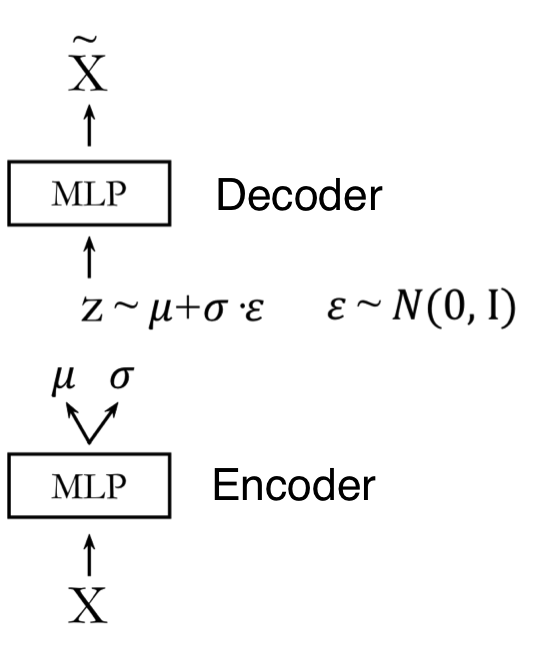

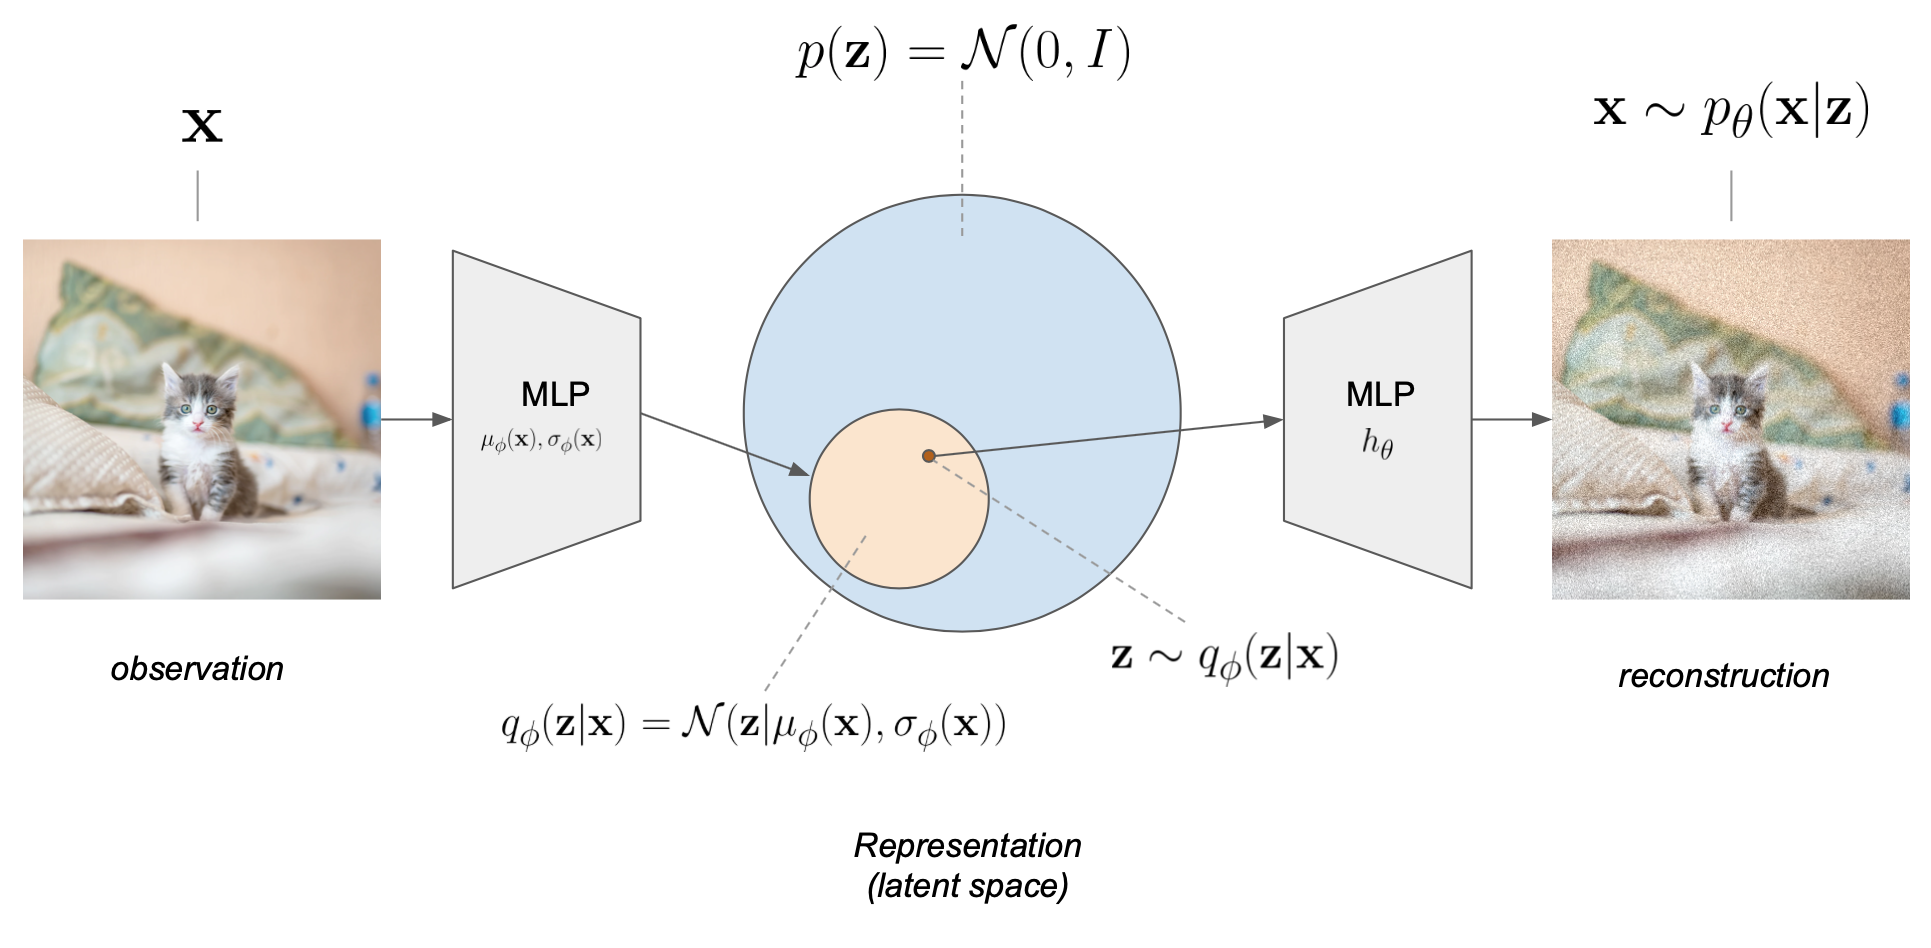

In [3]:
from IPython.display import Image
from IPython.display import display
display(Image('../static_files/VAE.png',width=300),\
Image('static/vae.png',width=600))

## VAE crash course

Like the simple auto-encoder, VAEs consist of two parts as seen in the figure below where all arrows are non-linear mappings through a neural network. The two parts are the:

 * **Encoder** (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space, z, by defining the mean and variance parameters of a Gaussian distribution as non-linear functions of the input data x like:
     - $q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x))$, which is called the approximate posterior or latent distribution. The parameters $\mu_\theta(x)$ (mean) and $\log \sigma_\phi(x)^2$ (log-variance) are outputs from a hidden layer each.
 * **Decoder** (also known as generative, reconstruction or P-model): Conditioned on samples drawn from $z \sim q(z|x)$ in the encoder the input data is reconstructed through the: 
     - $p(x|z)$, which is the conditional likelihood (generative distribution). The choice of the generative distribution depends on the nature of the features, so for binary pixel values an appropiate choice of reconstruction distribution is the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), $p(x|z) = Ber(\mu_\phi(z)) = \mu_\phi(z)^x(1-\mu_\phi(z))^{1-x}$. $\mu_\phi(z)$ with $x=\{0,1\}$ is again the non-linear output of the last layer in the decoder. $\mu_\phi(z)$ is the probabilities of generating a 0 (black) or 1 (white) pixel value, like modelling 784 imbalanced coin-tossing processes. This is only possible because we assume the pixel intensities to be i.i.d. (Independent and Identically Distributed), so no direct correlations between them needs to modelled, even though we still achieve an indirect conditional correlation through the latent variables, z.
     
<img src="../static_files/VAE.png" alt="Drawing" style="width: 300px;"/>

A different (and maybe nicer) representation of the same concept is represented in the following picture:

![Variational AutoEncoder model](static/vae.png)

In more mathematical details we can get the marginal likelihood for the features, e.g. binary pixel values, by integrating out the latent variable in the joint distribution:

$p(x) = \int_z p(x,z) dz = \int_z p(x|z)p(z)dz$

As a trick to introduce the approximate posterior, $q(z|x)$, which is more feasible to compute compared to our unknown true posterior, $p(z|x)$, we can always multiply and divide by $q(z|x)$ and move them around without changing anything:

$p(x) = \int_z p(x|z)p(z)\frac{q(z|x)}{q(z|x)}dz$


$p(x) = \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$

Joint distributions can lead to underflow errors on a compute, so we instead try to maximize the log-likelihood  

$\log p(x) = \log \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz = \log \mathbb{E}_{q(z|x)}\left[\frac{p(x|z)p(z)}{q(z|x)}\right]$

where we used that the integral is just the expectation (mean) wrt. $q(z|x)$ and in this case the $\log$ can be moved inside the expectation by applying [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality):

$\log p(x) \geq  \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz =  \mathbb{E}_{q(z|x)}\left[\log \frac{p(x|z)p(z)}{q(z|x)}\right] = \mathcal{L}(x)$

This, $\mathcal{L}(x)$, is denoted the variational lower bound or evidence lower bound objective (ELBO). It is a lower bound to the log-likelihood and a tradeoff with the Kullback-Leibler divergence, $KL[q(z|x) || p(z|x)]$, between the approximate and true posterior, which we threw away when applying Jensen's inequality. This tradeoff is more easily understood through the derivation in the end of the notebook, so read it if you have the time. 

Like with Pokemons, there is a whole range of families of distributions to choose from, but we choose the most common one describing symmetric variations around a mean in signals with noise, the normal distribution:

$q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$

and a simple isotropic normal distribution as the latent prior

$p(z) = \mathcal{N}(z|0, I)$

which becomes the part of the important regularising KL-term, when splitting up the lower bound as

$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$

This is the function that we need to maximise, by minimising the negative lower bound. Here the first term on the R.H.S. is the data reconstruction and the second term the Kullback-Leibler divergence between the approximate and true posterior distributions which acts as a probabilistic regularizer forcing $q(z|x)$ to be close to having zero mean and identity variance, like $p(z)$. The KL-term can calculated analytically and the reconstruction error, $\log p(x|z)$, is just the binary cross-entropy.

### Training a VAE 
The VAE is similar to a deterministic autoencoder (1.Auto_Encoders) except that we assume that the latent units follows a distribution. Usually we just assume that the units are independent standard normally distributed (i.i.d.).

Above we defined a lower bound on the log-likelihood of the data. We can train the model by maximising the lower bound w.r.t. the model parameters, weight matrices, through the stochastic gradient descent algorithm.  Feasible approximations of the expectations in the lower bound, $\mathcal{L}(x)$, are obtained by evaluating the inside with samples drawn from the latent distribution, $z \sim q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$ and dividing by the number of samples drawn. By using the _reparameterization trick_, $ \mu_\theta(x) + \sigma_\phi(x) \cdot \epsilon$, for the sampling procedure we can directly backpropogate gradients through the latent bottleneck and optimize the parameters w.r.t. the lower bound. 

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through the `classes` variable, to speed up training.

In [ ]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose
from functools import reduce

# Flatten the images into a vector
#flatten = lambda x: ToTensor()(x).view(28**2)

# we can compose the transformation of the input into a tensor and
# also the flatten operation
transformation = Compose([ToTensor(),
                         Lambda(lambda x: torch.flatten(x)),
                         Lambda(lambda x: torch.bernoulli(x))])

# Define the train and test sets
dset_train = MNIST("data/", train=True,  transform=transformation, download=True)
dset_test  = MNIST("data/", train=False, transform=transformation)

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets), pin_memory=cuda)

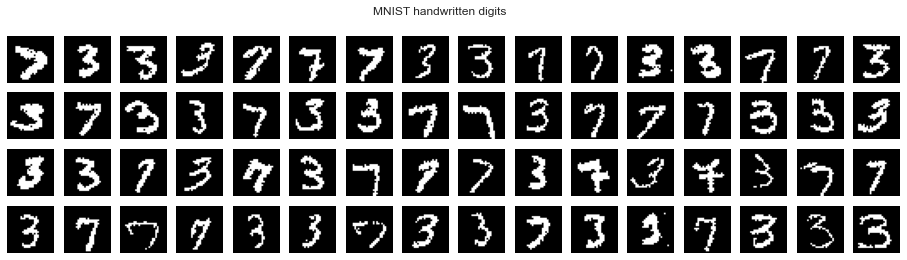

In [ ]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [ ]:
import torch.nn as nn
from torch.nn.functional import softplus
from torch.distributions import Normal, Bernoulli

# define size variables
num_features = 28**2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=128, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_features)
        )
        
        self.prior = Normal(0,1) 
        
    
    def encode(self, x, n_samples = None):
        # function that take an input and return
        # the mean and log_var that paremetrize the 
        # approximate posterior distribution q(z|x) 
        # the distribution and also a sample
        encoder_output = self.encoder(x)
        mu, log_var =  torch.split(encoder_output, 2, dim=1)
        
        # define q(z|x)
        q_zx =  Normal(mu, (0.5*log_var).exp())
        
        # we should sample from this distribution
        # using the reparametrization trick; this is 
        # easily done by using rsample(), which allows us 
        #to backporpagate the gradient through this 
        # operation
        if n_samples==1:
            z = q_zx.rsample()
        else:
            z = q_zx.rsample([n_samples])
            #z = z.permute(1,0,2)
        
        return mu, log_var, q_zx, z
        
        
    def decode(self, z):
        # function that takes a latent variable and
        # return the parametrization of a the distribution
        # used to model our input data, 
        # in this case a Bernoulli distribution and the 
        # distribution itself
        logits = self.decoder(z)
        
        output_dist = Bernoulli(logits=logits)
        
        return logits, output_dist
    
    
    def forward(self, x): 
        # we start by encoding our example x
        mu, log_var, q_zx, z = self.encode(x, self.num_samples)
        
        # and then decode it
        logits, output_dist = self.decode(z)
        
        #print(logits.shape)
        # I can already compute the KL 
        # KL(q(z|x)||p(z)) = ∫ q(z|x) log [ q(z) / p(z) ]
        #             =-E[log q(z|x) - log p(z)]
        #print(torch.sum(self.prior.log_prob(z), dim=[0,2]).shape)
        #print(torch.sum(q_zx.log_prob(z), dim=[0,2]).shape)
        
        if self.num_samples ==1:
            log_p = torch.sum(self.prior.log_prob(z), dim=1) # after the sum the dim is batch_size 
            log_q = torch.sum(q_zx.log_prob(z), dim=1) # after the sum the dim is batch_size 
            #print(output_dist.log_prob(x).shape)
            cond_likelihood = torch.sum(output_dist.log_prob(x), dim=1)
            
        else:
            log_p = torch.sum(self.prior.log_prob(z), dim=[0,2]) # after the sum the dim is batch_size 
            log_q = torch.sum(q_zx.log_prob(z), dim=[0,2]) # after the sum the dim is batch_size 
            #print(output_dist.log_prob(x).shape)
            cond_likelihood = torch.sum(output_dist.log_prob(x), dim=[0,2])
        
    
        
        
        kl = log_q - log_p
        
        # since here both the prior p(z) and the approximate posterior
        # q(z|x) are Gaussian, we can also compute the KL analytically
        # by doing
        #analytical_kl = - 0.5 * torch.sum(log_var + 1 - mu.pow(2) - log_var.exp(), dim=1)
        elbo = cond_likelihood - kl
        
        # now we have to create the output
        # we define a dictionary for the output
        outputs = { 'q_zx_mean': mu,
                    'q_zx_log_var': log_var,
                    'q_zx': q_zx,
                    'z': z,
                    'p_xz_logits': logits,
                    'p_xz': output_dist,
                    'kl': kl,
                    'cond_likelihood':cond_likelihood,
                    'elbo': elbo
                   }
        
        return outputs


latent_features = 2
num_samples = 1

model = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    model = model.cuda()

print(model)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
)


Test the forward pass, to check that everything is in order.

In [ ]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))

if cuda:
    x = x.cuda()

outputs = model(x)

mu, log_var = outputs["q_zx_mean"], outputs["q_zx_log_var"]
z = outputs["z"]
logits = outputs["p_xz_logits"]
kl = outputs["kl"]
elbo = outputs["elbo"]

# here you can note that the elbo is defined still for every example in the batch
print(x.shape)
print(z.shape)
print(elbo.shape) 
print(kl.shape)

torch.Size([64, 784])
torch.Size([64, 2])
torch.Size([64])
torch.Size([64])


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

Using device: cpu


Training loop 10: 100%|███████████████████████| 194/194 [00:02<00:00, 78.17it/s]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


samples shape:  torch.Size([64, 784])


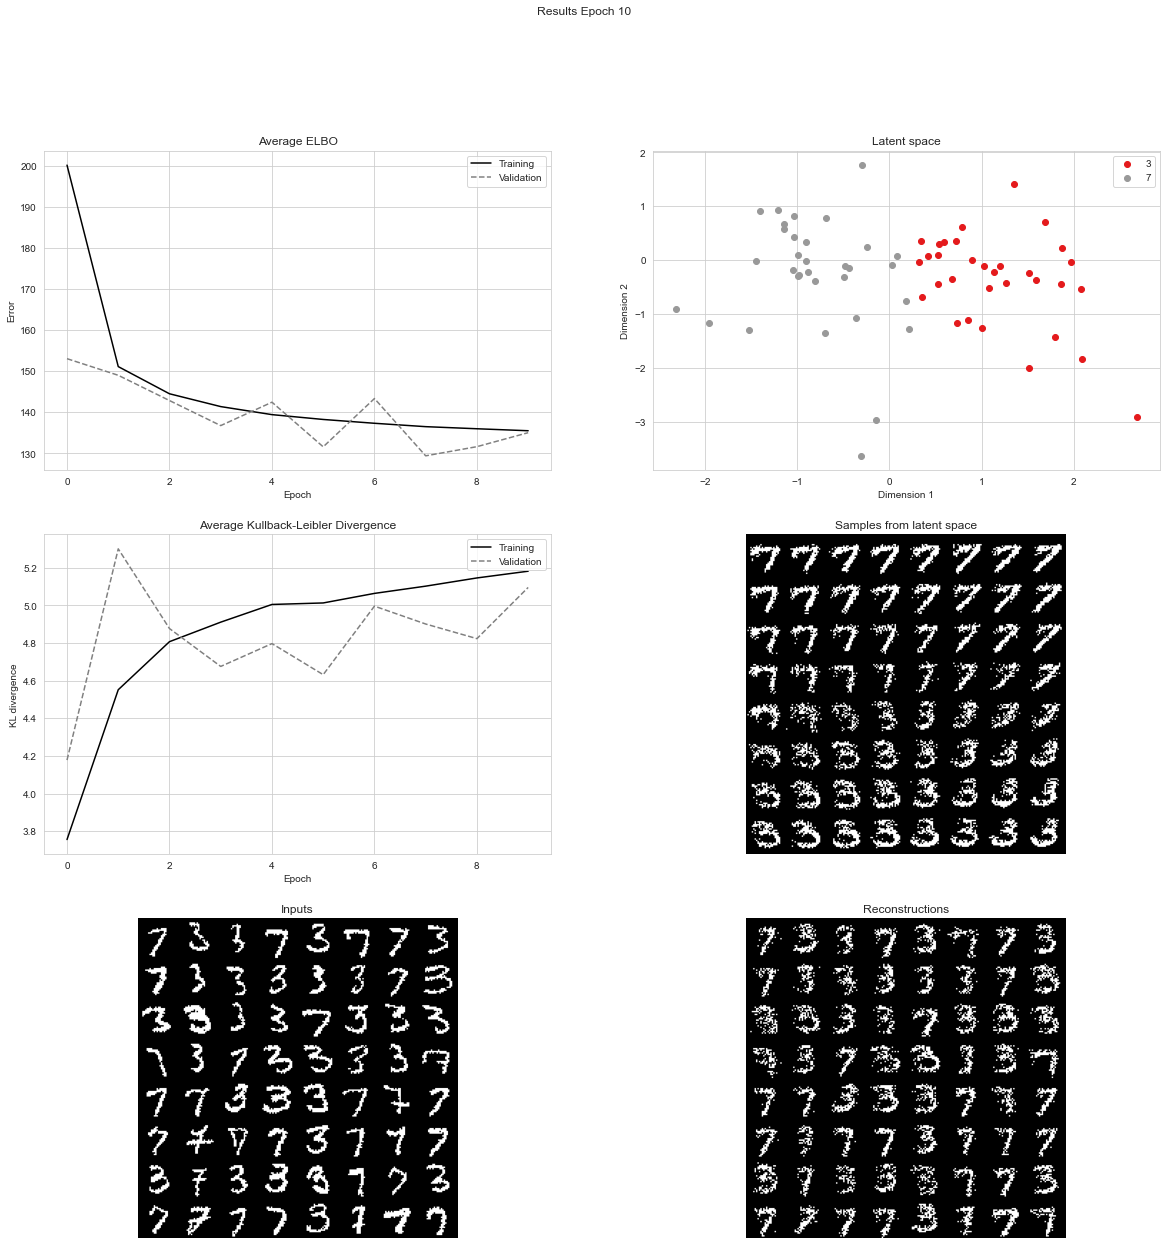

Training loop 20: 100%|███████████████████████| 194/194 [00:02<00:00, 74.88it/s]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [ ]:
import os
from torch import optim
from tqdm import tqdm

num_epochs = 100
tmp_img = "tmp_vae_out.png"
show_sampling_points = False

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    n_examples = 0
    model.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in tqdm(train_loader, desc=f'Training loop {epoch +1}'):
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        n_examples += len(x)
        # passing the input through the model
        outputs = model(x)
        
        loss = - torch.sum(outputs['elbo'])/len(x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item()*len(x))
        batch_kl.append(torch.sum(outputs["kl"]).item())

    train_loss.append(np.sum(batch_loss)/(n_examples*model.num_samples))
    train_kl.append(np.sum(batch_kl)/(n_examples*model.num_samples))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        model.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        x = x.to(device)
        
        valid_outputs = model(x)
         
        z = valid_outputs["z"]
        output_dist = valid_outputs["p_xz"]
        x_hat = output_dist.sample()
        
        if num_samples ==1:
            elbo = torch.sum(-valid_outputs["elbo"])/(len(x))
            kl = torch.sum(valid_outputs["kl"])/(len(x))
            # We save the latent variable and reconstruction for later use
            # we will need them on the CPU to plot
            x = x.to("cpu")
            x_hat = x_hat.to("cpu")
            z = z.detach().to("cpu").numpy()
        else:
            # taking the mean of the reconstruction along samples for the same example
            x_hat = torch.mean(x_hat, dim=0)
            elbo = torch.sum(-valid_outputs["elbo"])/(len(x) * model.num_samples)
            kl = torch.sum(valid_outputs["kl"])/(len(x) * model.num_samples)
            # We save the latent variable and reconstruction for later use
            # we will need them on the CPU to plot
            x = x.to("cpu")
            x_hat = x_hat.to("cpu")
            z = z.permute(1,0,2).detach().to("cpu").numpy()
            #print(z.shape)

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch == 0:
        continue
    
    elif (epoch+1) % 10 ==0:
        # -- Plotting --
        f, axarr = plt.subplots(3, 2, figsize=(20, 20))

        # Loss
        ax = axarr[0, 0]
        ax.set_title("Average ELBO")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Error')

        ax.plot(np.arange(epoch+1), train_loss, color="black")
        ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
        ax.legend(['Training', 'Validation'])

        # Latent space
        ax = axarr[0, 1]

        ax.set_title('Latent space')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')

        rows = 8
        columns = batch_size // rows

        span = np.linspace(-4, 4, rows)
        grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)

        # If you want to use a dimensionality reduction method you can use
        # for example PCA by projecting on two principal dimensions
        # z = PCA(n=2).fit_transform(z)

        colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
        for c in classes:
            ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)

        if show_sampling_points:
            ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

        ax.legend()

        # KL / reconstruction
        ax = axarr[1, 0]

        ax.set_title("Average Kullback-Leibler Divergence")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('KL divergence')


        ax.plot(np.arange(epoch+1), train_kl, color="black")
        ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
        ax.legend(['Training', 'Validation'])

        # Latent space samples
        ax = axarr[1, 1]
        ax.set_title('Samples from latent space')
        ax.axis('off')

        with torch.no_grad():
            # here we want to compute some samples
            # note that we are sampling in a grid center in (0,0)
            epsilon = torch.from_numpy(grid).float().to(device)
            logits, output_dist = model.decode(epsilon)
            samples = output_dist.sample().detach()
            #print('samples shape: ', samples.shape)

        canvas = np.zeros((28*rows, columns*28))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
        ax.imshow(canvas, cmap='gray')

        # Inputs
        ax = axarr[2, 0]
        ax.set_title('Inputs')
        ax.axis('off')

        canvas = np.zeros((28*rows, columns*28))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x[idx].reshape((28, 28))
        ax.imshow(canvas, cmap='gray')

        # Reconstructions
        ax = axarr[2, 1]
        ax.set_title('Reconstructions')
        ax.axis('off')

        canvas = np.zeros((28*rows, columns*28))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_hat[idx].reshape((28, 28))
        ax.imshow(canvas, cmap='gray')
        
        f.suptitle(f"Results Epoch {epoch+1}")
        plt.show()
#         plt.savefig(tmp_img)
#         plt.close(f)
#         display(Image(filename=tmp_img))
#         clear_output(wait=True)

#         os.remove(tmp_img)

# Analyzing the VAE

## Mandatory Exercises

- Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
- Try to increase the number of digit classes in the training set and analyze the learning curves, latent space and reconstructions. For which classes and why does the VAE fail in reconstructing?  *HINT: Try the combination: `classes=[0, 1, 4, 9]`, to see how well VAE can separate these digits in the latent representation and reconstructions.*
- Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions? *HINT: You can visualize the latent space in 2D by transforming z to a lower dimensional representation with [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)*

**Answers**:

### 2. Analyze the purpose of the KL-term

- How does the KL-term, $KL[q(z|x)||p(z)]$, work as a regulariser on the distributions over latent variables? *HINT*: When maximising the ELBO, the probability-distance measure is minimised $KL[q(z|x)||p(z)] \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $KL[q(z|x)||p(z)] = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal $z=\epsilon$ to the decoder.
- Try removing the KL-term ($KL \cdot 0$ in `ELBO_loss`) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it.
- Notice what the loss reduces to and explain how this can affect a VAE. *HINT*: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p(x|z) = \log Ber(\mu_\phi(z))$, in VAEs.

**Answers**:

### 3. Increasing samples for estimating the KL and the conditional likelihood

- At the moment we are using only one sample for estimating the KL and the reconstruction term (Note that this is the usual way people is using VAEs). Experiment with `num_samples` used when initialising the VAE. Does it improve the reconstructions and how/why?

**Answers**:

## Optional exercises

- OPT: Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.
- OPT: Look through https://arxiv.org/abs/1611.00712 or https://arxiv.org/abs/1611.01144 and explain how one could instead introduce a categorical latent variable for $z$.
- OPT: Implement the Gumbel softmax trick thereby letting $z$ take a categorical distribution.
- OPT: The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf or again the two papers on Gumbel softmax.

**Answers**:

### The tradeoff connection between the lower bound and KL-divergence
To understand this tradeoff connection, we flip the whole problem around into the perspective of the KL-divergence

$KL[q(z|x) || p(z|x)] = \int_z q(z|x)\log \frac{q(z|x)}{p(z|x)}dz = \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z|x)}\right]$,

which is a non-negative distance measure between distributions, so by minimising it wrt. to the parameters in $q(z|x)$, the distribution moves close to our unknown $p(z|x)$. But as $p(z|x)$ is unknown and would include some rather intractable integrals over neural networks, we can instead get rid of it by expressing it through Bayes rule $p(z|x) = p(x|z)p(z)/p(x)$ and thereby decompose the KL-divergence into our log-likelihood and lower bound:

$ KL[q(z|x) || p(z|x)] = \int_z q(z|x)\log \frac{q(z|x)p(x)}{p(x|z)p(z)}dz = \int_z q(z|x)\log \frac{q(z|x)}{p(x|z)p(z)}dz + \log p(x)$ 

by seeing that the likelihood, $p(x)$, is independent of $z$ and pull it out of the integral. We can flip the sign and fraction in the integral term to recognise it as the negative lower bound

$KL[q(z|x) || p(z|x)] = - \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz + \log p(x) =  -\mathcal{L}(x) + \log p(x)$

We then find the log-likelihood to consist of the two terms and hold the inequality

$\log p(x) =  KL[q(z|x) || p(z|x)] + \mathcal{L}(x) \geq \mathcal{L}(x)$

where the KL-divergence is non-zero and the log-likelihood is $\log p(x) \leq 0$. This means that maximising the lower bound from the negative domain towards $0$ will also maximise the log-likelihood, while pushing down the KL-divergence until $q(z|x)$ cannot move closer to natures true distribution, $p(z|x)$. So how close the lower bound can get to the log-likelihood is dependent on the flexibility of the distribution we choose for $q(z|x)$. 

## Credits 

> Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow and updated by 
Maximillian F. Vording ([maximillian91](https://github.com/maximillian91)).
Converted to PyTorch and updated by Jesper Wohlert ([wohlert](https://github.com/wohlert)).
Transform the code by using torch.distributions and binarized MNIST by Federico Bergamin ([federicobergamin](https://github.com/federicobergamin)).